In [1]:
import pandas as pd
import scipy as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
import matplotlib.dates as mdates
import datetime as dt

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

plt.style.use('seaborn')

warnings.filterwarnings('ignore')


%matplotlib inline

In [2]:
def get_csvs_paths(dataset_dir):
    result = {}
    for d, dirs, files in os.walk(dataset_dir):
        for name in files:
            if '.swp' in name:
                continue
            result[name] = dataset_dir + '/' + name
    
    return result

In [3]:
def extract_dataset(csv_path):
    df = pd.read_csv(csv_path)
    df['time'] = '2018_' + df['time']
    df['time'] = pd.to_datetime(df['time'], format='%Y_%d_%m_%H:%M')
    
    instances = pd.unique(df['instance'])
    
    return df, instances

def extract_csv(csv_path):
    df = pd.read_csv(csv_path)
    df['time'] = '2018_' + df['time']
    df['time'] = pd.to_datetime(df['time'], format='%Y_%d_%m_%H:%M')
    
    return df

In [4]:
total = pd.DataFrame()
for name, path in get_csvs_paths('final/train_us3').items():
    df = extract_csv(path)
    if len(total.columns) == 0:
        print('new df - %s' % (name))
        total = df
    else:
        print('merging - %s' % (name))
        total = pd.merge(total, df, on=['time', 'instance'])

total_cols = [
    'time',
    'abgw_write_reqs_total',
    'abgw_read_reqs_total',
    'abgw_stat_reqs_total',
    'abgw_req_errs_total',
    'abgw_iop_latency_ms_count',
    'abgw_detached_files_rate',
    'abgw_detached_files',
    'abgw_fds',
    'abgw_io_limiting_failures_total',
    'abgw_iop_latency_ms_rate',
    'abgw_iop_latency_ms_sum',
    'abgw_write_rollback_bytes_total',
    'abgw_write_rollback_bytes_rate',
    'abgw_req_errs_rate',
    'abgw_account_lookup_errs_total',
    'instance',
]

total.rename(columns=lambda c: c.replace('abgw_', ''), inplace=True)

new df - abgw_write_rollback_bytes_total.csv
merging - abgw_account_lookup_errs_rate.csv
merging - abgw_file_lookup_errs_rate.csv
merging - abgw_write_reqs_total.csv
merging - abgw_iop_latency_ms_count.csv
merging - abgw_iop_latency_ms_sum.csv
merging - abgw_account_pull_errs_rate.csv
merging - abgw_account_pull_errs_total.csv
merging - abgw_account_lookup_errs_total.csv
merging - abgw_detached_files_rate.csv
merging - abgw_write_rollback_bytes_rate.csv
merging - abgw_req_errs_total.csv
merging - abgw_detached_files.csv
merging - abgw_stat_reqs_total.csv
merging - abgw_fds.csv
merging - abgw_io_limiting_failures_total.csv
merging - abgw_iop_latency_ms_rate.csv
merging - abgw_io_limiting_failures_rate.csv
merging - abgw_req_errs_rate.csv
merging - abgw_read_reqs_total.csv


In [5]:
total.drop(['account_pull_errs_rate', 'account_pull_errs_total'], inplace=True, axis=1)
total.columns

Index([u'time', u'write_rollback_bytes_total', u'instance',
       u'account_lookup_errs_rate', u'file_lookup_errs_rate',
       u'write_reqs_total', u'iop_latency_ms_count', u'iop_latency_ms_sum',
       u'account_lookup_errs_total', u'detached_files_rate',
       u'write_rollback_bytes_rate', u'req_errs_total', u'detached_files',
       u'stat_reqs_total', u'fds', u'io_limiting_failures_total',
       u'iop_latency_ms_rate', u'io_limiting_failures_rate', u'req_errs_rate',
       u'read_reqs_total'],
      dtype='object')

In [6]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92793 entries, 0 to 92792
Data columns (total 20 columns):
time                          92793 non-null datetime64[ns]
write_rollback_bytes_total    92793 non-null int64
instance                      92793 non-null object
account_lookup_errs_rate      92793 non-null float64
file_lookup_errs_rate         92793 non-null float64
write_reqs_total              92793 non-null int64
iop_latency_ms_count          92793 non-null int64
iop_latency_ms_sum            92793 non-null float64
account_lookup_errs_total     92793 non-null int64
detached_files_rate           92793 non-null float64
write_rollback_bytes_rate     92793 non-null float64
req_errs_total                92793 non-null int64
detached_files                92793 non-null int64
stat_reqs_total               92793 non-null int64
fds                           92793 non-null int64
io_limiting_failures_total    92793 non-null int64
iop_latency_ms_rate           92793 non-null float64
io

In [7]:
instances = pd.unique(total['instance'])
print('amount of instances %d' %(len(instances)))

amount of instances 24


In [8]:
example_node = total[total['instance'] == instances[0]]
example_node = example_node.drop(['time', 'instance'], axis=1)

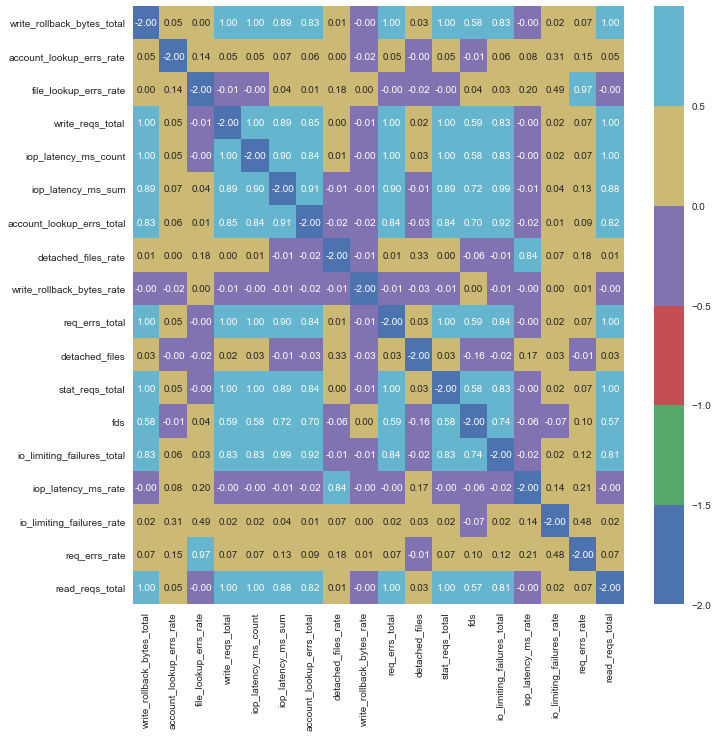

In [9]:
corrs = example_node.corr()
np.fill_diagonal(corrs.values, -2)
fig, ax = plt.subplots(figsize=(11,11))
sns.heatmap(corrs, annot=True, fmt=".2f", cmap=sns.color_palette("deep"), ax=ax)

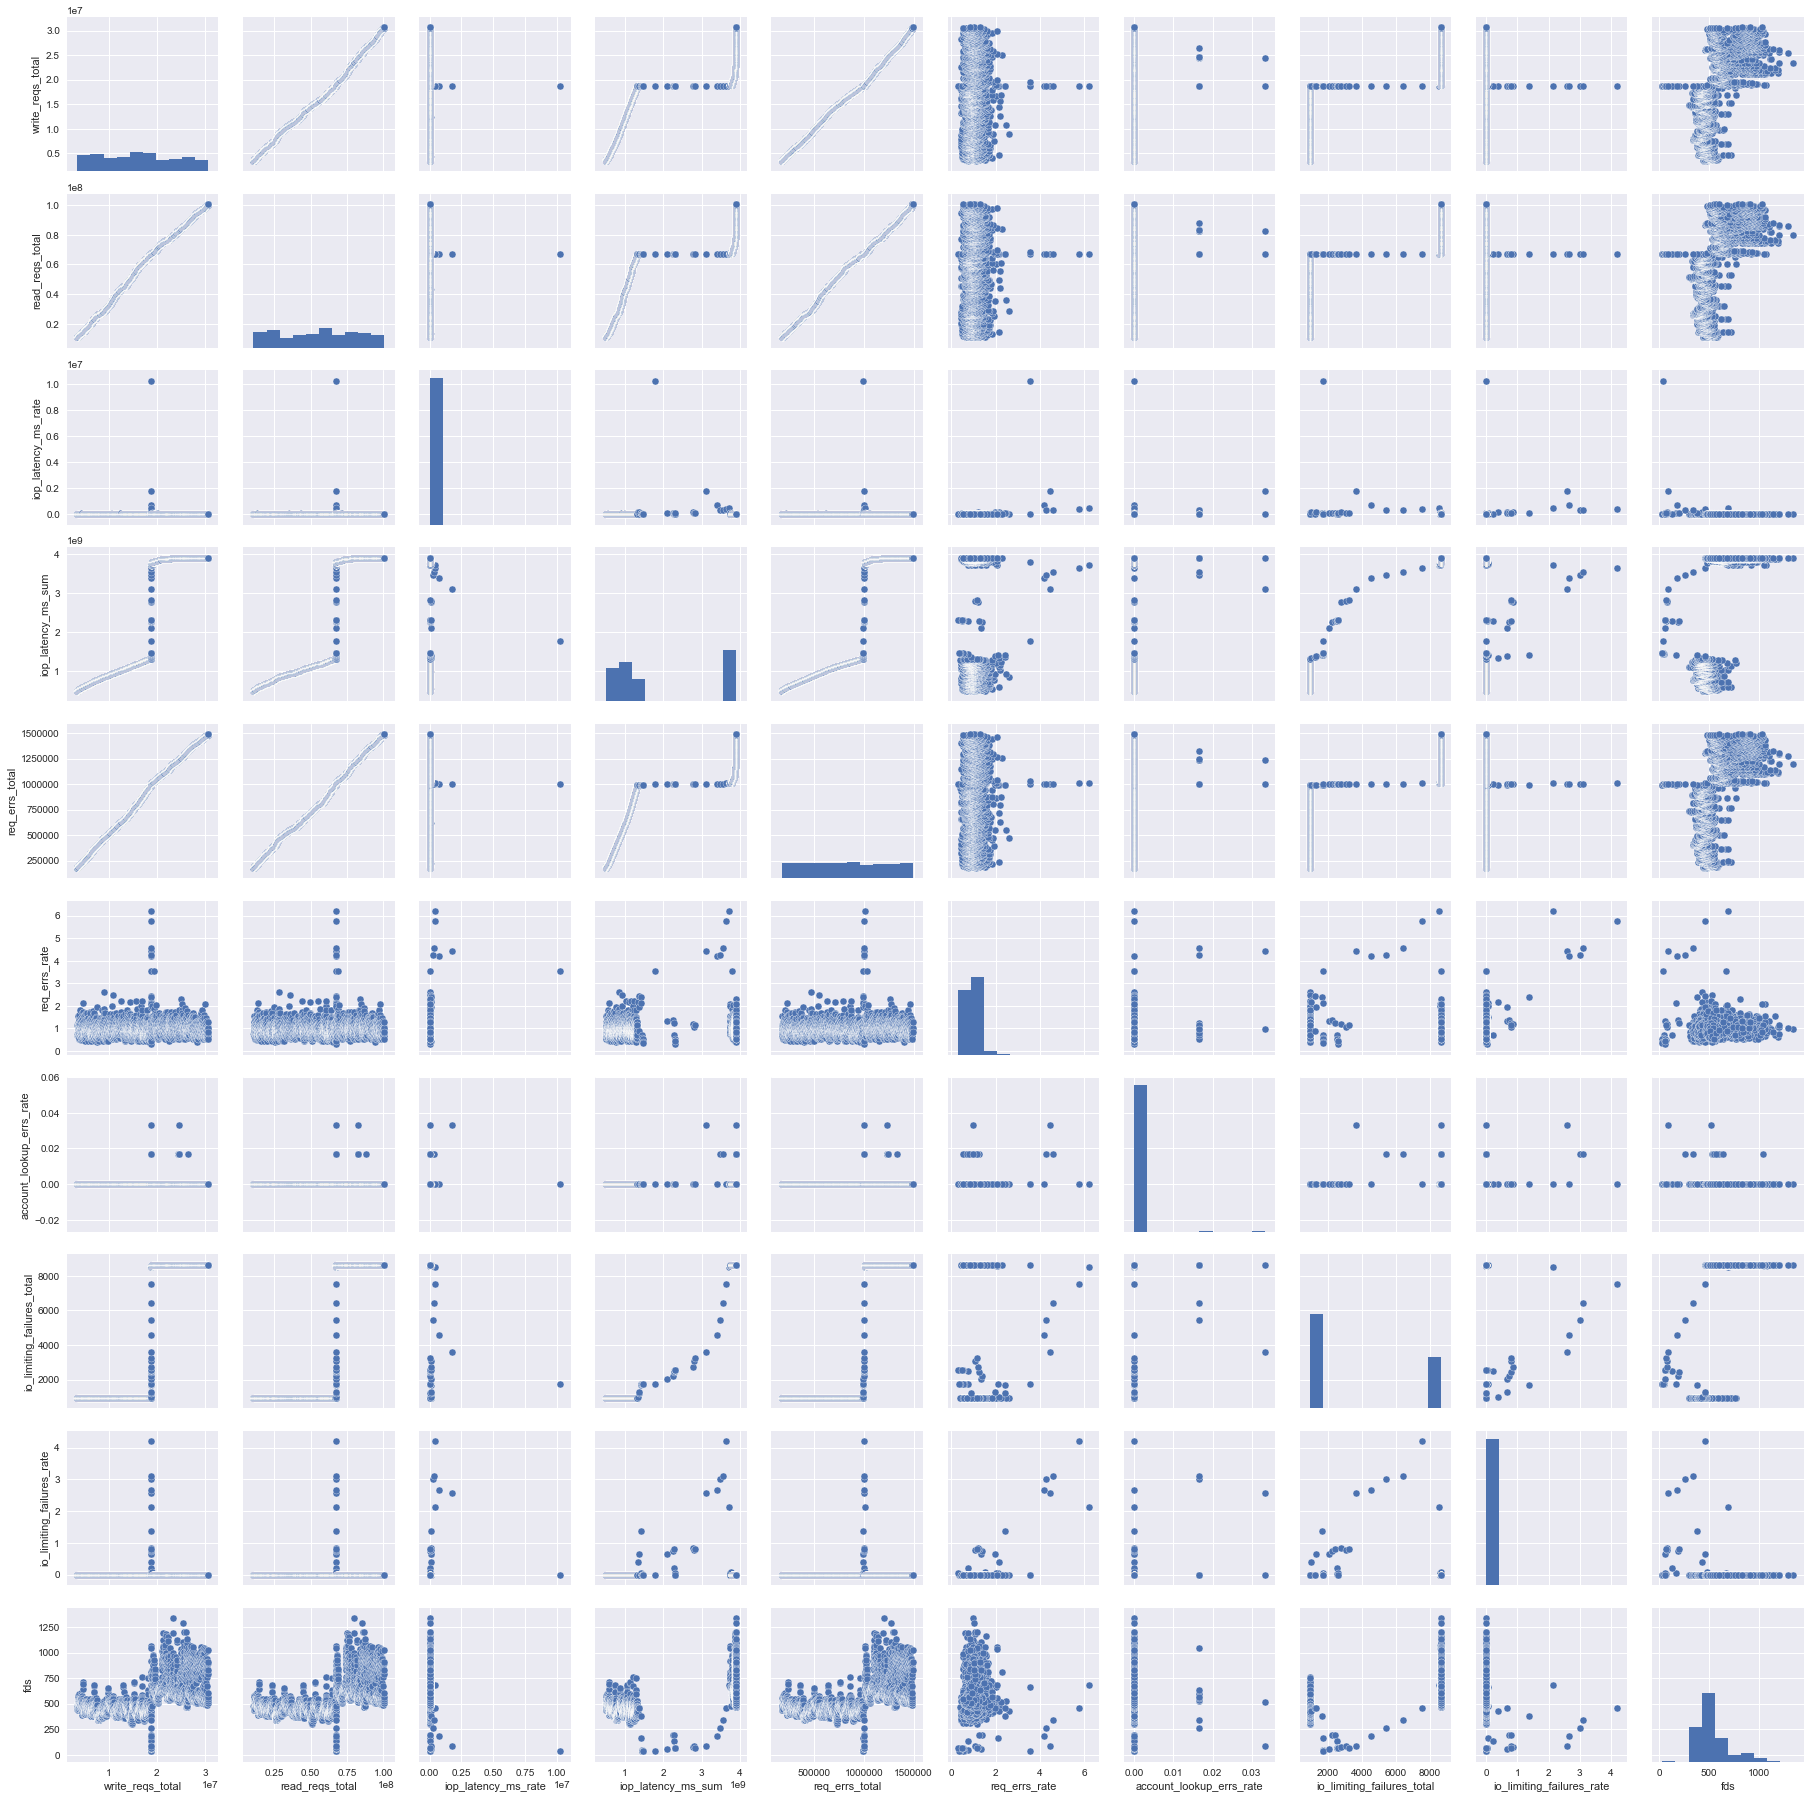

In [10]:
key_cols = ['write_reqs_total',
            'read_reqs_total',
            'iop_latency_ms_rate',
            'iop_latency_ms_sum',
            'req_errs_total',
            'req_errs_rate',
            'account_lookup_errs_rate',
            'io_limiting_failures_total',
            'io_limiting_failures_rate',
            'fds']
sns.pairplot(example_node[key_cols])

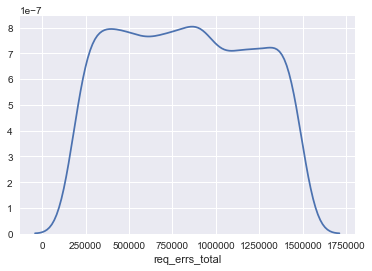

In [11]:
sns.distplot(example_node['req_errs_total'], hist=False)

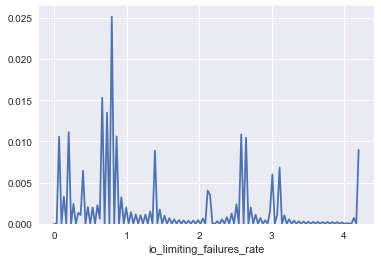

In [12]:
sns.distplot(example_node['io_limiting_failures_rate'], hist=False)

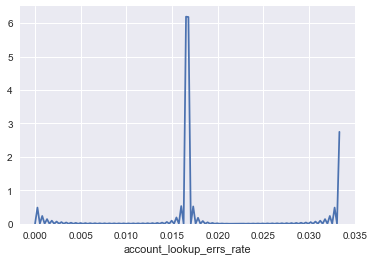

In [13]:
sns.distplot(example_node['account_lookup_errs_rate'], hist=False)

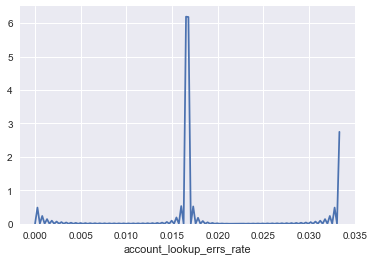

In [14]:
sns.distplot(example_node['account_lookup_errs_rate'], hist=False)

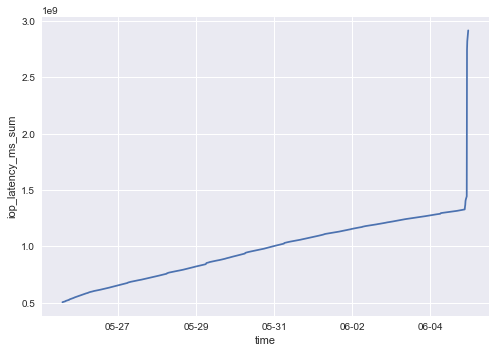

In [77]:
plt.style.use('seaborn')
example_node = total[total['instance'] == instances[11]]
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
plt.plot(example_node['time'], example_node['iop_latency_ms_sum'])
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.show()

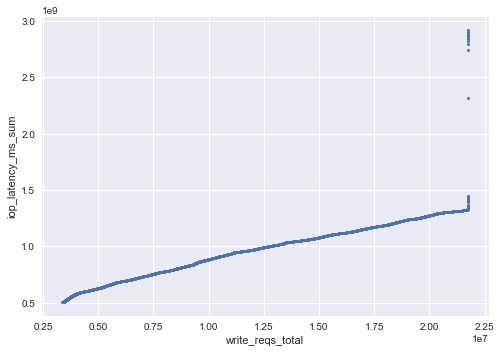

In [78]:
plt.plot(example_node['write_reqs_total'], example_node['iop_latency_ms_sum'], linestyle='none', marker='o',
         markersize=3)
plt.xlabel('write_reqs_total')
plt.ylabel('iop_latency_ms_sum')
plt.show()

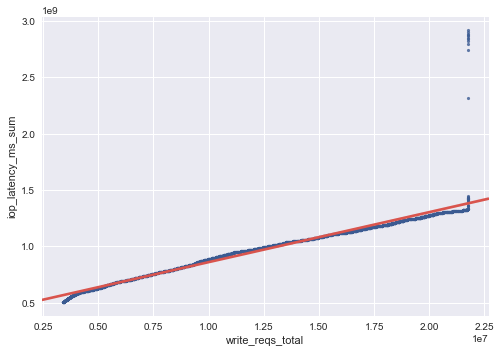

In [79]:
sns.regplot(x='write_reqs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s": 10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

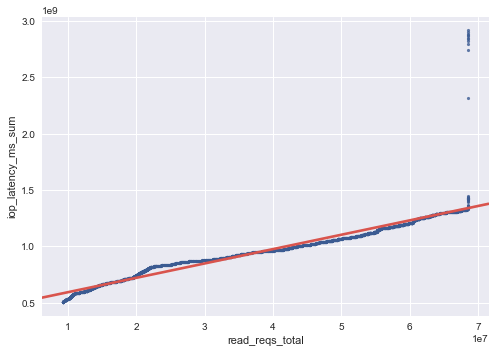

In [80]:
sns.regplot(x='read_reqs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s": 10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

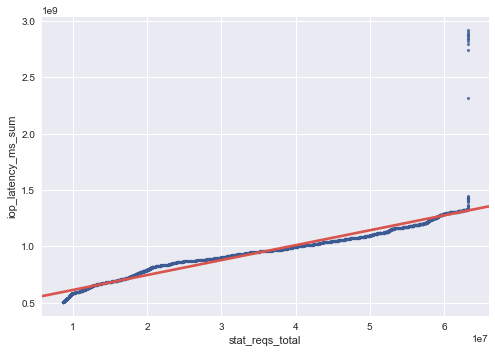

In [81]:
sns.regplot(x='stat_reqs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s":10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

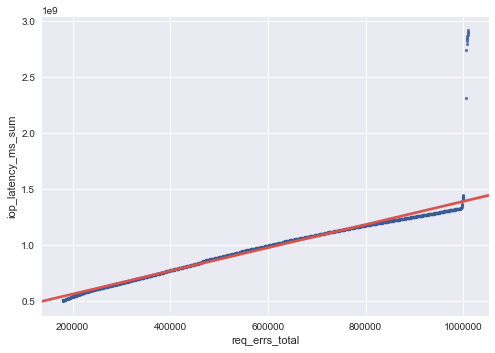

In [82]:
sns.regplot(x='req_errs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s":10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

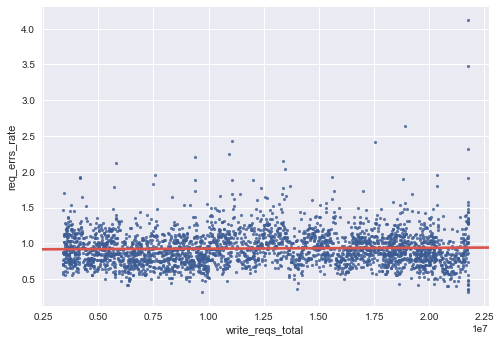

In [83]:
sns.regplot(x='write_reqs_total', y='req_errs_rate', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s":10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

In [84]:
train_data = example_node[-1000:-500]
test_data = example_node[-500:]

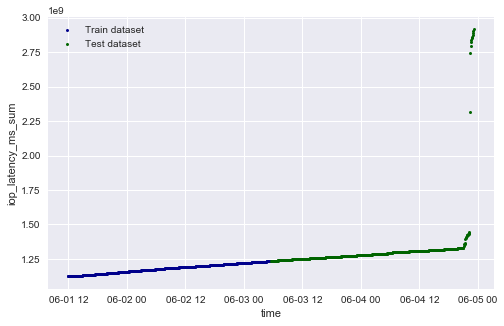

In [85]:
fig, ax = plt.subplots(figsize=(8, 5))
train_line, = plt.plot(train_data['time'], train_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkblue',
                      markersize=3)
test_line, = plt.plot(test_data['time'], test_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkgreen',
                      markersize=3)
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([train_line, test_line], ['Train dataset', 'Test dataset'])
plt.show()

In [86]:
def detect_anomaly(row):
    if row['upper_border'] < row['iop_latency_ms_sum']:
        return 1
    
    return 0

predictors = [
    'write_reqs_total',
    'read_reqs_total',
    'write_rollback_bytes_total',
    'stat_reqs_total',
    'req_errs_total',
]

regression_model = linear_model.Lasso()
regression_model.fit(train_data[predictors], train_data['iop_latency_ms_sum'])

test_data['iop_latency_ms_predict'] = regression_model.predict(test_data[predictors])
test_data['upper_border'] = test_data['iop_latency_ms_predict'] + train_data['iop_latency_ms_sum'].std()
test_data['is_anomaly'] = test_data.apply(lambda row: detect_anomaly(row), axis=1)

normal_data = test_data[test_data['is_anomaly'] == 0]
anomaly_data = test_data[test_data['is_anomaly'] == 1]

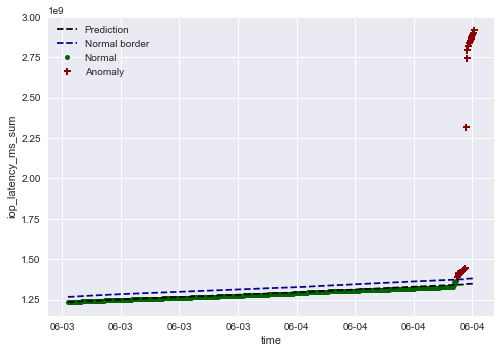

In [87]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
normal_dots, = plt.plot(normal_data['time'], normal_data['iop_latency_ms_sum'],
                        linestyle='none', marker='o', color='darkgreen',
                        markersize=5)
anomaly_dots, = plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_sum'],
                         linestyle='none', marker='P', color='darkred',
                         markersize=7)
predict_line, = plt.plot(test_data['time'], test_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
upper_border, = plt.plot(test_data['time'], test_data['upper_border'],
                         linestyle='--', color='darkblue')
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([predict_line, upper_border, normal_dots, anomaly_dots], ['Prediction', 'Normal border', 'Normal',
                                                                     'Anomaly'])
plt.show()

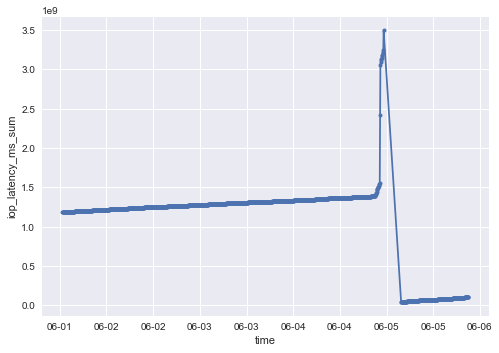

In [88]:
example_node = total[total['instance'] == instances[3]][2000:3200]
train_data = example_node[:700]
test_data = example_node[700:]

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))

plt.plot(example_node['time'], example_node['iop_latency_ms_sum'], marker='o', markersize=4)
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.show()

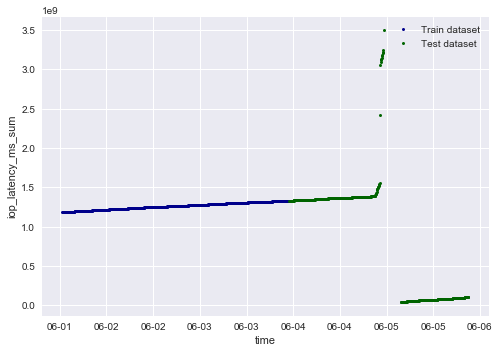

In [89]:
fig, ax = plt.subplots()

ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))

train_line, = plt.plot(train_data['time'], train_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkblue',
                      markersize=3)
test_line, = plt.plot(test_data['time'], test_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkgreen',
                      markersize=3)
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([train_line, test_line], ['Train dataset', 'Test dataset'])
plt.show()

In [90]:
regression_model = linear_model.Lasso()
regression_model.fit(train_data[predictors], train_data['iop_latency_ms_sum'])

test_data['iop_latency_ms_predict'] = regression_model.predict(test_data[predictors])
test_data['upper_border'] = test_data['iop_latency_ms_predict'] + train_data['iop_latency_ms_sum'].std()
test_data['is_anomaly'] = test_data.apply(lambda row: detect_anomaly(row), axis=1)

normal_data = test_data[test_data['is_anomaly'] == 0]
anomaly_data = test_data[test_data['is_anomaly'] == 1]

last_anomaly_index = anomaly_data.index.max()
before_anomaly_indexes = [x for x in normal_data.index if x <= last_anomaly_index]
after_anomaly_indexes = [x for x in normal_data.index if x > last_anomaly_index]

before_anomaly_data = test_data.ix[before_anomaly_indexes]
after_anomaly_data = test_data.ix[after_anomaly_indexes]

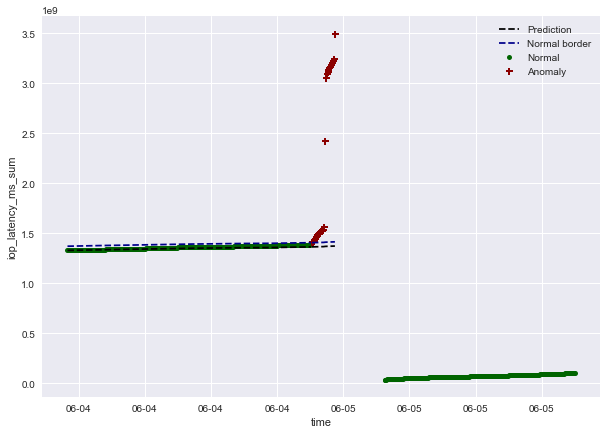

In [91]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

normal_dots, = plt.plot(normal_data['time'], normal_data['iop_latency_ms_sum'],
                        linestyle='none', marker='o', color='darkgreen',
                        markersize=5)
anomaly_dots, = plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_sum'],
                         linestyle='none', marker='P', color='darkred',
                         markersize=7)
predict_line, = plt.plot(before_anomaly_data['time'], before_anomaly_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
upper_border, = plt.plot(before_anomaly_data['time'], before_anomaly_data['upper_border'],
                         linestyle='--', color='darkblue')

plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
plt.plot(anomaly_data['time'], anomaly_data['upper_border'],
                         linestyle='--', color='darkblue')
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([predict_line, upper_border, normal_dots, anomaly_dots], ['Prediction', 'Normal border', 'Normal',
                                                                     'Anomaly'])
plt.show()

In [92]:
last_anomaly_index = anomaly_data.index.max()
first_anomaly_index = anomaly_data.index.min()
after_anomaly_indexes = [x for x in normal_data.index if x > last_anomaly_index]
after_anomaly_data = test_data.ix[after_anomaly_indexes]

with_anomaly_indexes = [x for x in test_data.index if x >= first_anomaly_index]
with_anomaly = test_data.ix[with_anomaly_indexes]

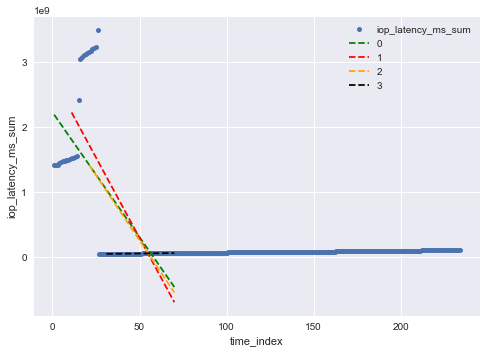

In [93]:
r_values = dict()
iter_limit = 4
shift_length = 10

x = np.arange(1, with_anomaly.shape[0] + 1)
y = with_anomaly['iop_latency_ms_sum']
plt.plot(x, y, linestyle='none', marker='o', markersize=5, label='iop_latency_ms_sum')

colors = ['green', 'red', 'orange', 'black']

x = x[:70]
y = y[:70]

for i in range(iter_limit):
    a, b, r_value, p_value, stderr = ss.stats.linregress(x,y)
    plt.plot(x, a * x + b, linestyle='--', color=colors[i], label=str(i))
    r_values[r_value] = [a, b]
    
    x = x[shift_length:]
    y = y[shift_length:]

plt.ylabel('iop_latency_ms_sum')
plt.xlabel('time_index')
plt.legend()
plt.show()

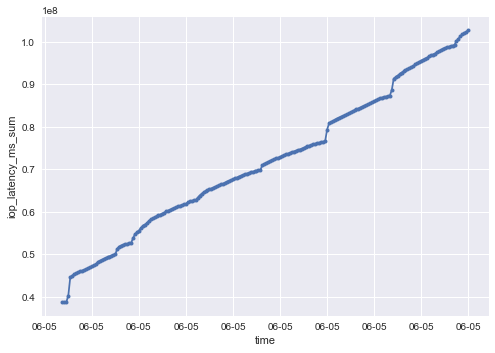

In [94]:
#fig, ax = plt.subplots()
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
#plt.plot(after_anomaly_data['time'], after_anomaly_data['iop_latency_ms_sum'], marker='o', markersize=4)
#plt.xlabel('time')
#plt.ylabel('iop_latency_ms_sum')
#plt.show()

In [95]:
regression_model = linear_model.LinearRegression()
regression_model.fit(after_anomaly_data[predictors], after_anomaly_data['iop_latency_ms_sum'])

after_anomaly_data['iop_latency_ms_predict'] = regression_model.predict(after_anomaly_data[predictors])
after_anomaly_data['upper_border'] = after_anomaly_data['iop_latency_ms_predict'] + \
                        train_data['iop_latency_ms_sum'].std()

In [99]:
#fig, ax = plt.subplots()
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
#plt.plot(after_anomaly_data['time'], after_anomaly_data['iop_latency_ms_sum'], marker='o', markersize=4)
#plt.plot(after_anomaly_data['time'], after_anomaly_data['iop_latency_ms_predict'], linestyle='--',
#         color='black')
#plt.xlabel('time')
#plt.ylabel('iop_latency_ms_sum')
#plt.legend()
#plt.show()

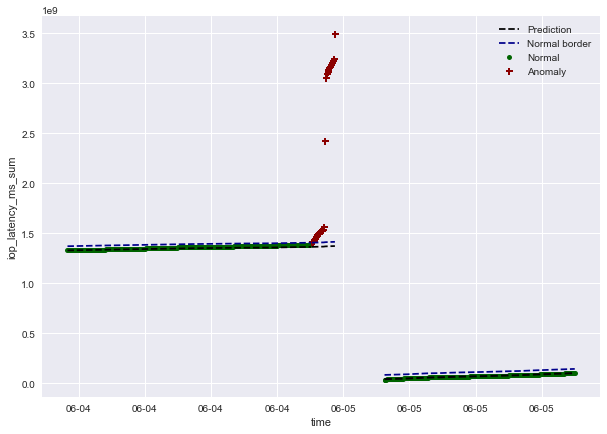

In [97]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

normal_dots, = plt.plot(normal_data['time'], normal_data['iop_latency_ms_sum'],
                        linestyle='none', marker='o', color='darkgreen',
                        markersize=5)
anomaly_dots, = plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_sum'],
                         linestyle='none', marker='P', color='darkred',
                         markersize=7)
predict_line, = plt.plot(before_anomaly_data['time'], before_anomaly_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
upper_border, = plt.plot(before_anomaly_data['time'], before_anomaly_data['upper_border'],
                         linestyle='--', color='darkblue')

plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_predict'],
         linestyle='--', color='black')
plt.plot(anomaly_data['time'], anomaly_data['upper_border'],
         linestyle='--', color='darkblue')
plt.plot(after_anomaly_data['time'], after_anomaly_data['upper_border'], linestyle='--',
         color='darkblue')
plt.plot(after_anomaly_data['time'], after_anomaly_data['iop_latency_ms_predict'], linestyle='--',
         color='black', linewidth=2)

plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([predict_line, upper_border, normal_dots, anomaly_dots], ['Prediction', 'Normal border', 'Normal',
                                                                     'Anomaly'])
plt.show()

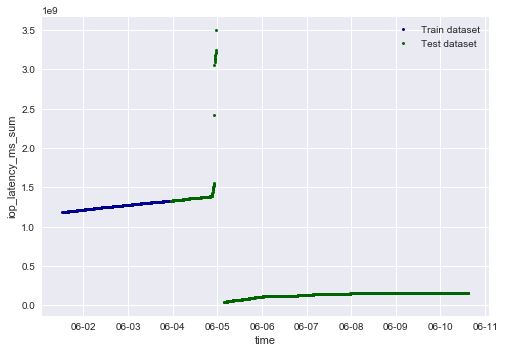

In [181]:
example_node = total[total['instance'] == instances[3]][2000:]
train_data = example_node[:700]
test_data = example_node[700:]

fig, ax = plt.subplots()

ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))

train_line, = plt.plot(train_data['time'], train_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkblue',
                      markersize=3)
test_line, = plt.plot(test_data['time'], test_data['iop_latency_ms_sum'],
                      linestyle='none', marker='o', color='darkgreen',
                      markersize=3)
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([train_line, test_line], ['Train dataset', 'Test dataset'])
plt.show()

In [182]:
regression_model = linear_model.Lasso()
regression_model.fit(train_data[predictors], train_data['iop_latency_ms_sum'])

test_data['iop_latency_ms_predict'] = regression_model.predict(test_data[predictors])
test_data['upper_border'] = test_data['iop_latency_ms_predict'] + train_data['iop_latency_ms_sum'].std()
test_data['is_anomaly'] = test_data.apply(lambda row: detect_anomaly(row), axis=1)

normal_data = test_data[test_data['is_anomaly'] == 0]
anomaly_data = test_data[test_data['is_anomaly'] == 1]

last_anomaly_index = anomaly_data.index.max()
first_anomaly_idnex = anomaly_data.index.min()
before_anomaly_indexes = [x for x in normal_data.index if x <= first_anomaly_index]
after_anomaly_indexes = [x for x in normal_data.index if x > last_anomaly_index]

before_anomaly_data = test_data.ix[before_anomaly_indexes]
after_anomaly_data = test_data.ix[after_anomaly_indexes]

In [183]:
after_anomaly_data.shape[0]

1575

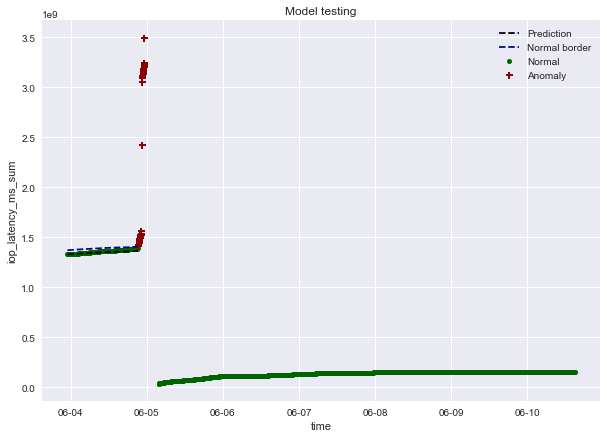

In [184]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

normal_dots, = plt.plot(normal_data['time'], normal_data['iop_latency_ms_sum'],
                        linestyle='none', marker='o', color='darkgreen',
                        markersize=5)
anomaly_dots, = plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_sum'],
                         linestyle='none', marker='P', color='darkred',
                         markersize=7)
predict_line, = plt.plot(before_anomaly_data['time'], before_anomaly_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
upper_border, = plt.plot(before_anomaly_data['time'], before_anomaly_data['upper_border'],
                         linestyle='--', color='darkblue')

#plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_predict'],
#                         linestyle='--', color='black')
#plt.plot(anomaly_data['time'], anomaly_data['upper_border'],
#                         linestyle='--', color='darkblue')
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([predict_line, upper_border, normal_dots, anomaly_dots], ['Prediction', 'Normal border', 'Normal',
                                                                     'Anomaly'])
plt.title('Model testing')
plt.show()

ValueError: Inputs must not be empty.

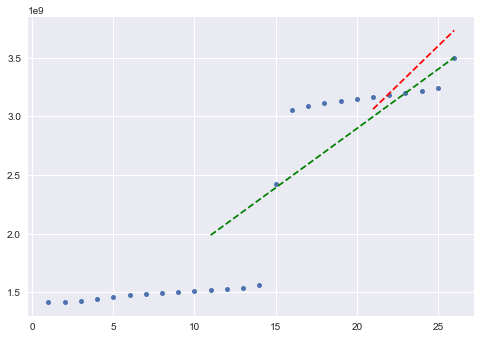

In [185]:
relearning_data = anomaly_data[:200]

r_values = dict()
iter_limit = 4
shift_length = 10
normal_range_start = 1

x = np.arange(1, relearning_data.shape[0] + 1)
y = relearning_data['iop_latency_ms_sum']
plt.plot(x, y, linestyle='none', marker='o', markersize=5, label='iop_latency_ms_sum')

colors = ['green', 'red', 'orange', 'black']

for i in range(iter_limit):
    a, b, r_value, p_value, stderr = ss.stats.linregress(x,y)
    r_values[r_value] = [a, b]
    
    x = x[shift_length:]
    y = y[shift_length:]
    relearning_data = relearning_data[shift_length:]
    
    plt.plot(x, a * x + b, linestyle='--', color=colors[i], label=str(i))

plt.ylabel('iop_latency_ms_sum')
plt.xlabel('time_index')
plt.title('Hyper-parameters update process')
plt.legend()
plt.show()

In [178]:
first_normal_index = relearning_data.index.min()
clean_data_indexes = [x for x in anomaly_data.index if x >= first_normal_index]
anomaly_data_indexes = [x for x in anomaly_data.index if x < first_normal_index]
clean_data = anomaly_data.ix[clean_data_indexes]
anomaly_data = anomaly_data.ix[anomaly_data_indexes]

In [179]:
regression_model.fit(clean_data[predictors], clean_data['iop_latency_ms_sum'])

clean_data['iop_latency_ms_predict'] = regression_model.predict(clean_data[predictors])
clean_data['upper_border'] = clean_data['iop_latency_ms_predict'] + clean_data['iop_latency_ms_sum'].std() * 1.05

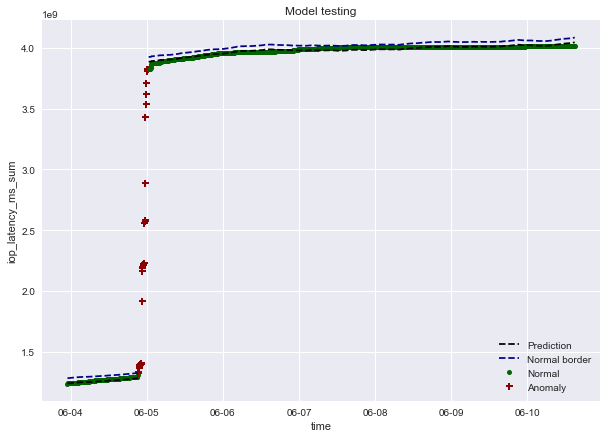

In [180]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

normal_dots, = plt.plot(normal_data['time'], normal_data['iop_latency_ms_sum'],
                        linestyle='none', marker='o', color='darkgreen',
                        markersize=5)
anomaly_dots, = plt.plot(anomaly_data['time'], anomaly_data['iop_latency_ms_sum'],
                         linestyle='none', marker='P', color='darkred',
                         markersize=7)
predict_line, = plt.plot(before_anomaly_data['time'], before_anomaly_data['iop_latency_ms_predict'],
                         linestyle='--', color='black')
upper_border, = plt.plot(before_anomaly_data['time'], before_anomaly_data['upper_border'],
                         linestyle='--', color='darkblue')

plt.plot(clean_data['time'], clean_data['iop_latency_ms_sum'],
         linestyle='none', marker='o', markersize=5, color='darkgreen')
plt.plot(clean_data['time'], clean_data['iop_latency_ms_predict'],
         linestyle='--', color='black')
plt.plot(clean_data['time'], clean_data['upper_border'],
         linestyle='--', color='darkblue')

plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.legend([predict_line, upper_border, normal_dots, anomaly_dots], ['Prediction', 'Normal border', 'Normal',
                                                                     'Anomaly'])
plt.title('Model testing')
plt.show()

KeyboardInterrupt: 

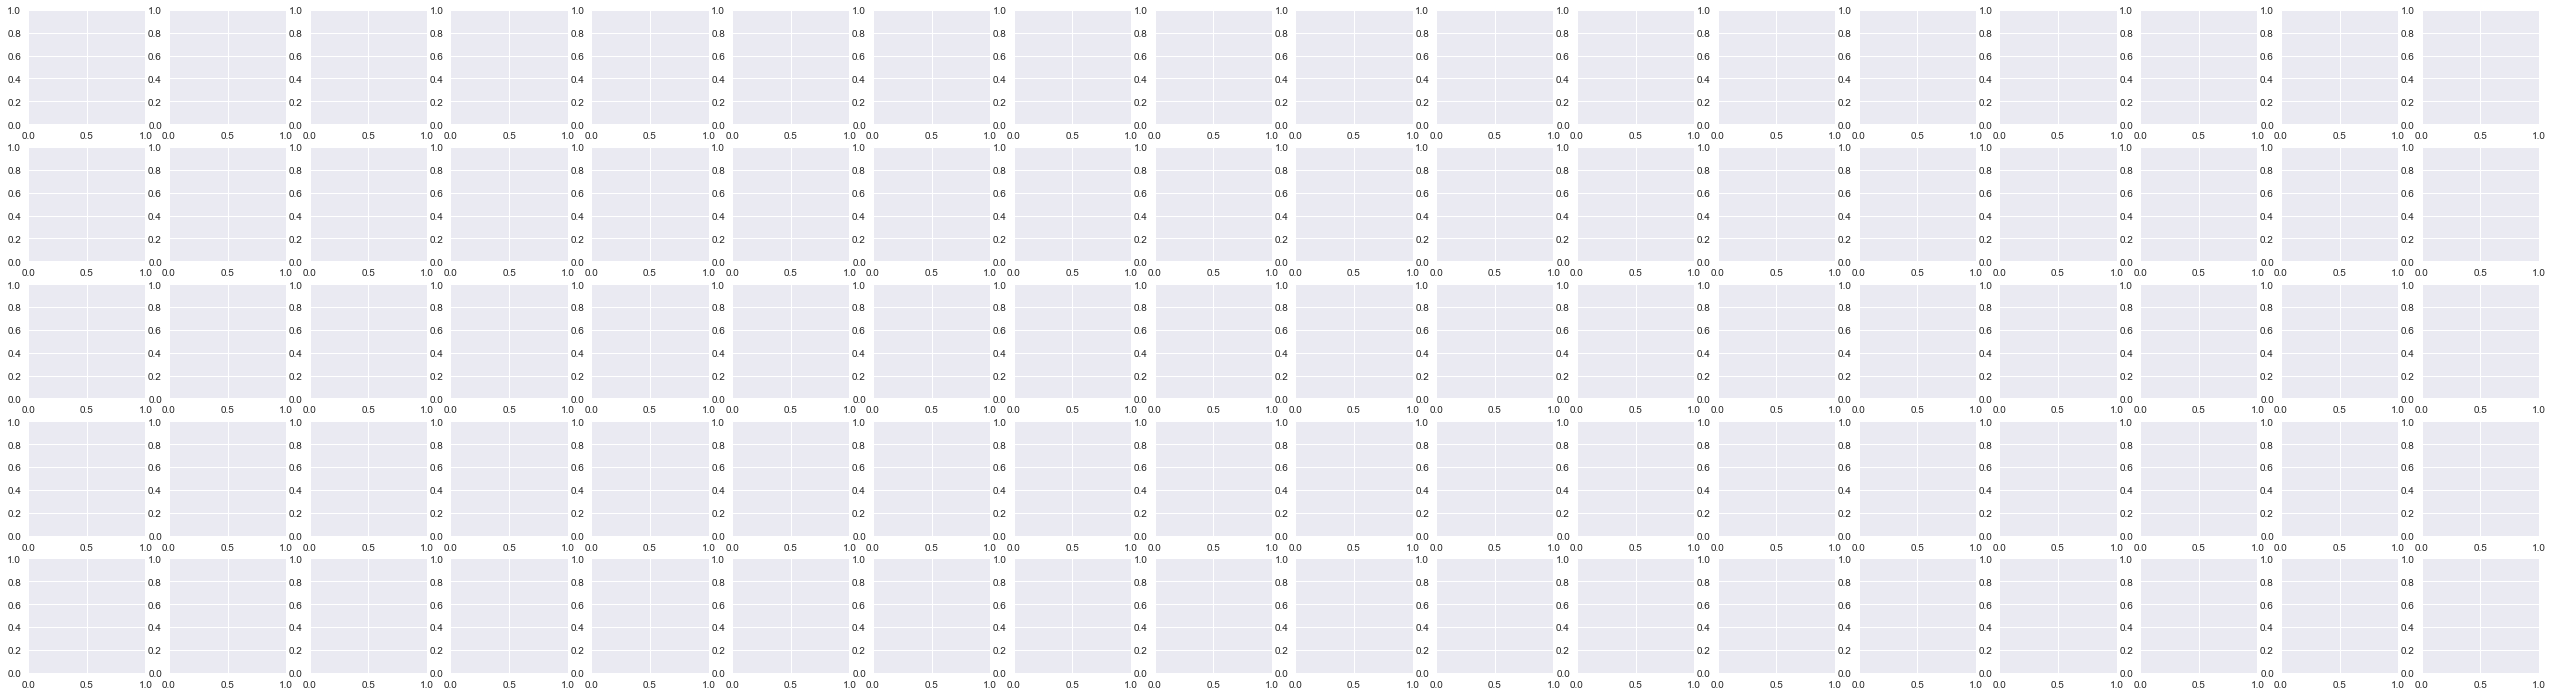

In [72]:
sns.pairplot(example_node)

In [ ]:
sns.jointplot(y='detached_files_rate', x='fds', data=example_node, kind='reg')

In [ ]:
sns.distplot(example_node['write_rollback_bytes_total'], hist=False)